In [5]:
import pandas as pd
import numpy as np
import math
import sys
import os


In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from scipy.stats.mstats import mquantiles

from plotnine import * 

In [7]:
import pymc3 as pm
import arviz as az

#import aesara
#import aesara.tensor as at
import theano.tensor as tt

In [8]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [9]:
from scipy import optimize
from prophet import Prophet

In [10]:
data = pd.read_csv("/Users/mahrukhwaqar/datascience/recruitment_challenge/MMM_test_data.csv")

In [11]:
data

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,06-09-20,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,13-09-20,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,20-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,27-09-20,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48
...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50,0.00,1118.78,22305.10,4566.01,2987.70,0.00,19916.88
100,31-07-22,90786.21,0.00,122.16,15812.65,4795.51,3293.40,0.00,22687.98
101,07-08-22,105929.40,0.00,754.09,12166.85,4961.12,4057.03,0.00,30142.64
102,14-08-22,90506.31,0.00,1043.22,10856.58,4431.13,3086.81,0.00,28622.78


In [12]:
#print(type('revenue'))
print(data.dtypes)

start_of_week       object
revenue            float64
spend_channel_1    float64
spend_channel_2    float64
spend_channel_3    float64
spend_channel_4    float64
spend_channel_5    float64
spend_channel_6    float64
spend_channel_7    float64
dtype: object


In [13]:
#data['revenue'] = data['revenue'].astype(float)

In [14]:
print(type('spend_channel_2'))

<class 'str'>


In [18]:
X = data.drop(columns=['revenue', 'start_of_week'])
y = data["revenue"]

In [19]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [20]:

with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'revenue',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_spend_channel_7, sat_spend_channel_7, coef_spend_channel_7, car_spend_channel_6, sat_spend_channel_6, coef_spend_channel_6, car_spend_channel_5, sat_spend_channel_5, coef_spend_channel_5, car_spend_channel_4, sat_spend_channel_4, coef_spend_channel_4, car_spend_channel_3, sat_spend_channel_3, coef_spend_channel_3, car_spend_channel_2, sat_spend_channel_2, coef_spend_channel_2, car_spend_channel_1, sat_spend_channel_1, coef_spend_channel_1]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 77 seconds.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


# posteriors for all parameters

array([[<AxesSubplot:title={'center':'coef_spend_channel_1'}>,
        <AxesSubplot:title={'center':'sat_spend_channel_1'}>,
        <AxesSubplot:title={'center':'car_spend_channel_1'}>,
        <AxesSubplot:title={'center':'coef_spend_channel_2'}>],
       [<AxesSubplot:title={'center':'sat_spend_channel_2'}>,
        <AxesSubplot:title={'center':'car_spend_channel_2'}>,
        <AxesSubplot:title={'center':'coef_spend_channel_3'}>,
        <AxesSubplot:title={'center':'sat_spend_channel_3'}>],
       [<AxesSubplot:title={'center':'car_spend_channel_3'}>,
        <AxesSubplot:title={'center':'coef_spend_channel_4'}>,
        <AxesSubplot:title={'center':'sat_spend_channel_4'}>,
        <AxesSubplot:title={'center':'car_spend_channel_4'}>],
       [<AxesSubplot:title={'center':'coef_spend_channel_5'}>,
        <AxesSubplot:title={'center':'sat_spend_channel_5'}>,
        <AxesSubplot:title={'center':'car_spend_channel_5'}>,
        <AxesSubplot:title={'center':'coef_spend_channel_6'}>]

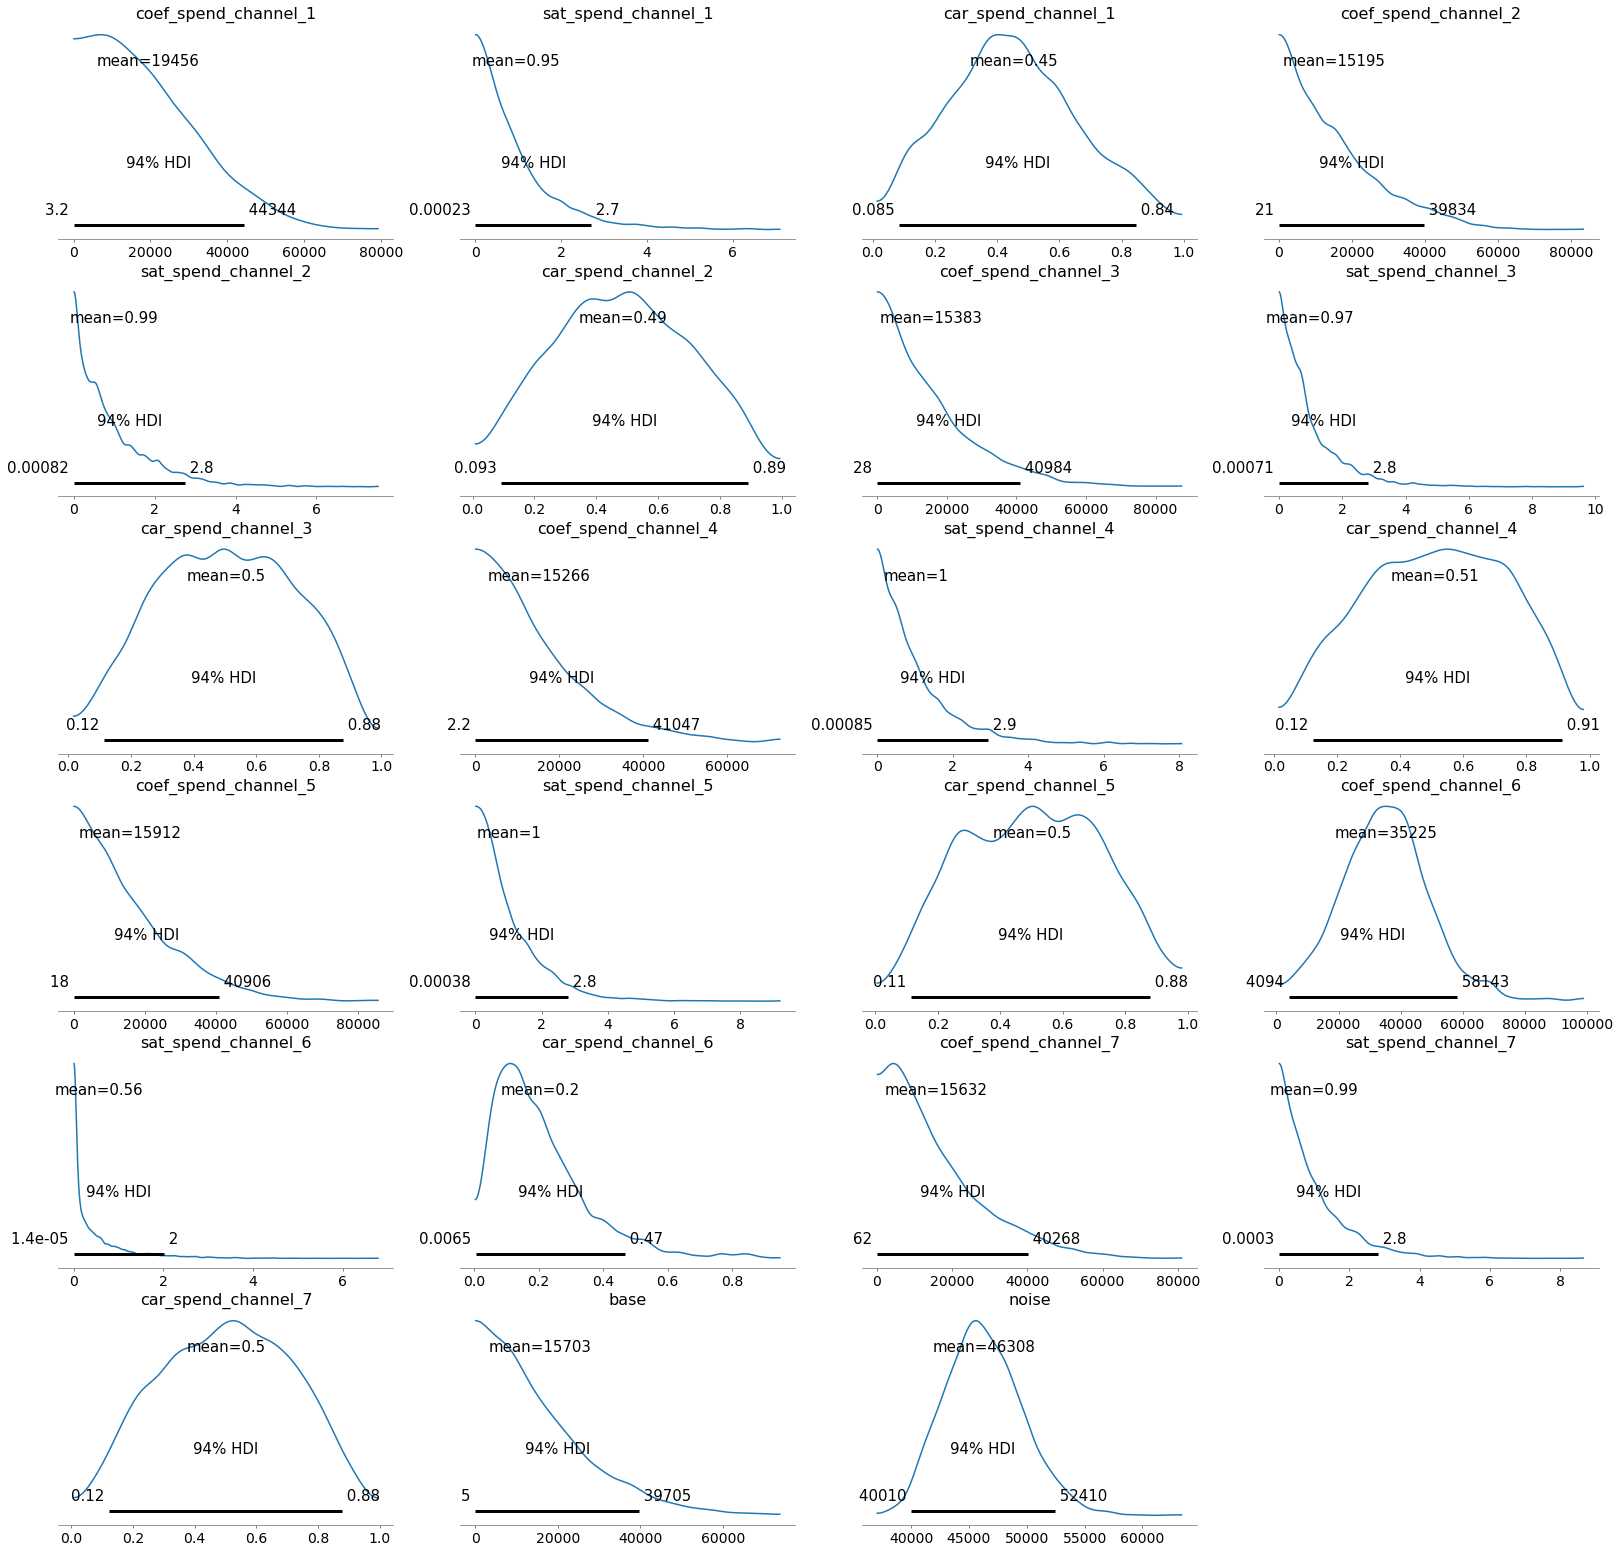

In [21]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

# Pairs of variables

array([[<AxesSubplot:ylabel='sat_spend_channel_1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='coef_spend_channel_1', ylabel='car_spend_channel_1'>,
        <AxesSubplot:xlabel='sat_spend_channel_1'>]], dtype=object)

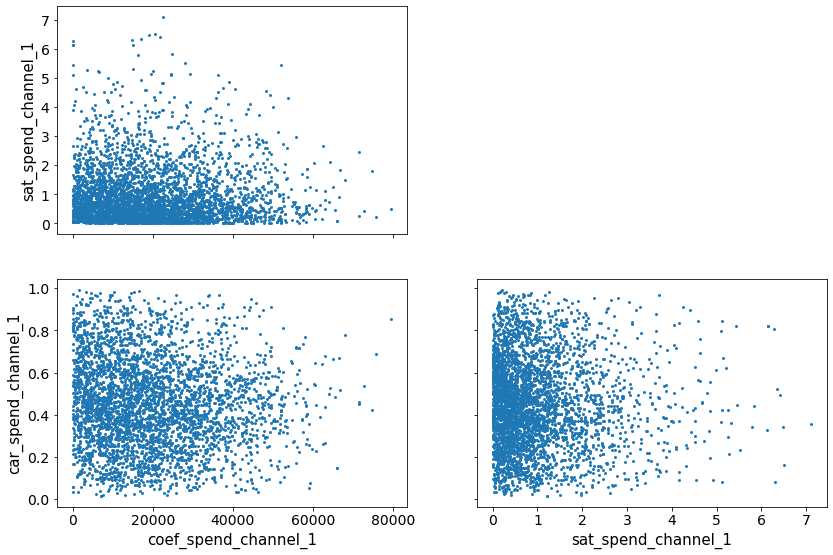

In [25]:
az.plot_pair(
    trace,
    var_names=['coef_spend_channel_1', 'sat_spend_channel_1', 'car_spend_channel_1' ],
)

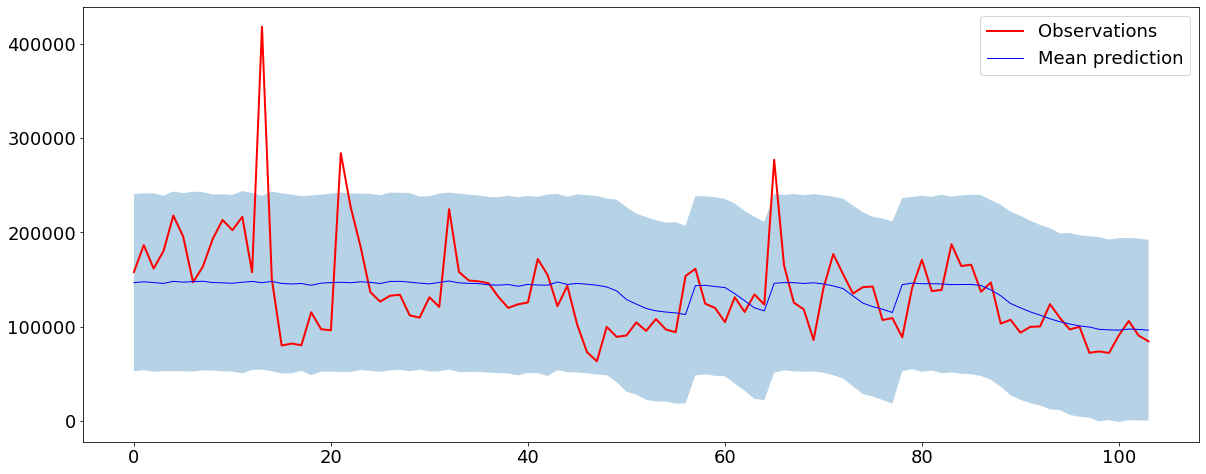

In [27]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)

means = posterior['revenue'].mean(0)
stds = posterior['revenue'].std(0)

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

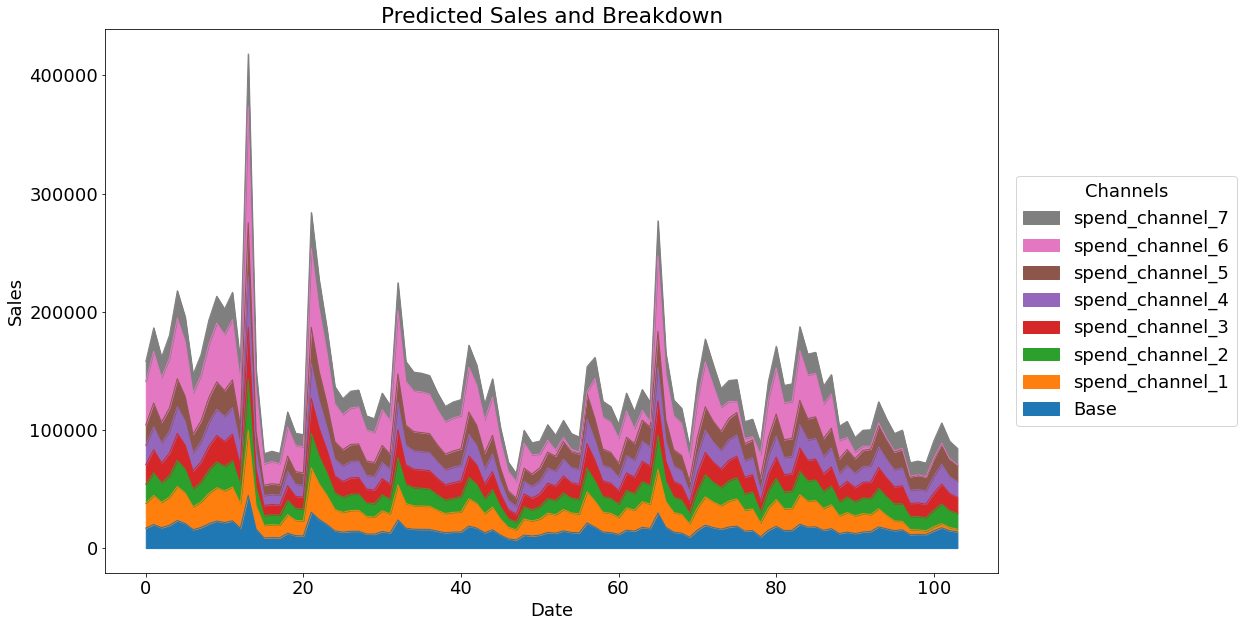

In [31]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 104)
            .mean(0)
           )

channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)